In [1]:
from datetime import date, timedelta
from constants import *
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data, best_data
from zoe import latest_map_data as zoe_map_data
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
for_date = '*'

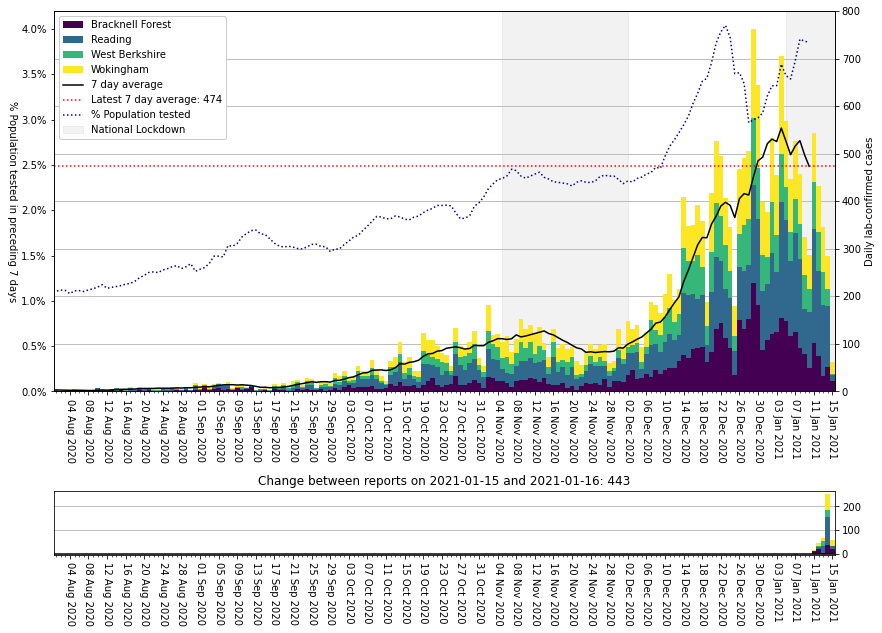

In [21]:
plot_areas(for_date, areas=my_areas)

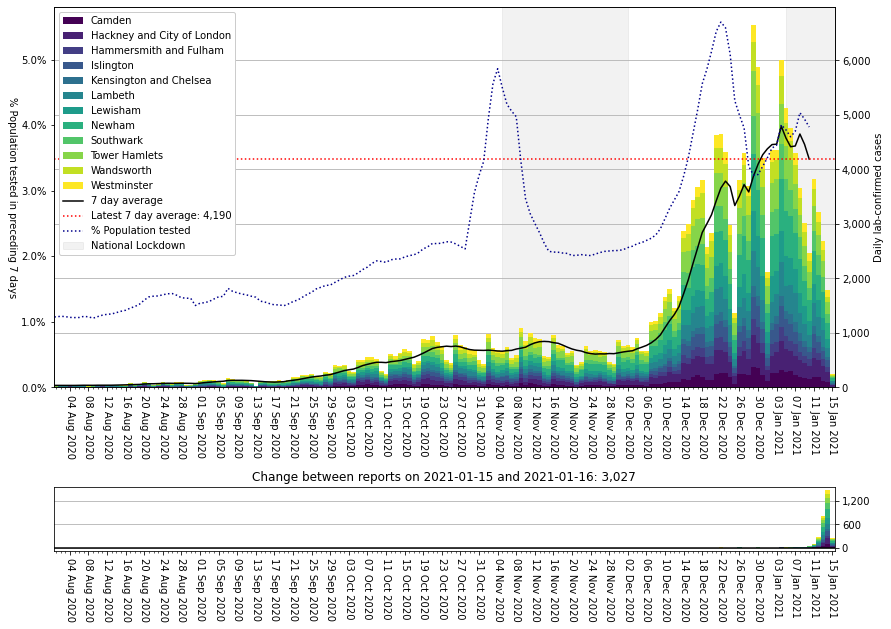

In [22]:
plot_areas(for_date, areas=london_areas)

In [7]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [8]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"cases per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000011,Knowsley,990.309024,1494.0,2021-01-15
E06000039,Slough,844.595724,1263.0,2021-01-15
E09000002,Barking and Dagenham,802.701662,1709.0,2021-01-15
E06000006,Halton,796.692682,1031.0,2021-01-15
E08000028,Sandwell,790.379053,2596.0,2021-01-15
E09000025,Newham,769.396320,2717.0,2021-01-15
E09000005,Brent,766.895816,2529.0,2021-01-15
E07000028,Carlisle,764.644178,831.0,2021-01-15
E08000031,Wolverhampton,752.590590,1982.0,2021-01-15


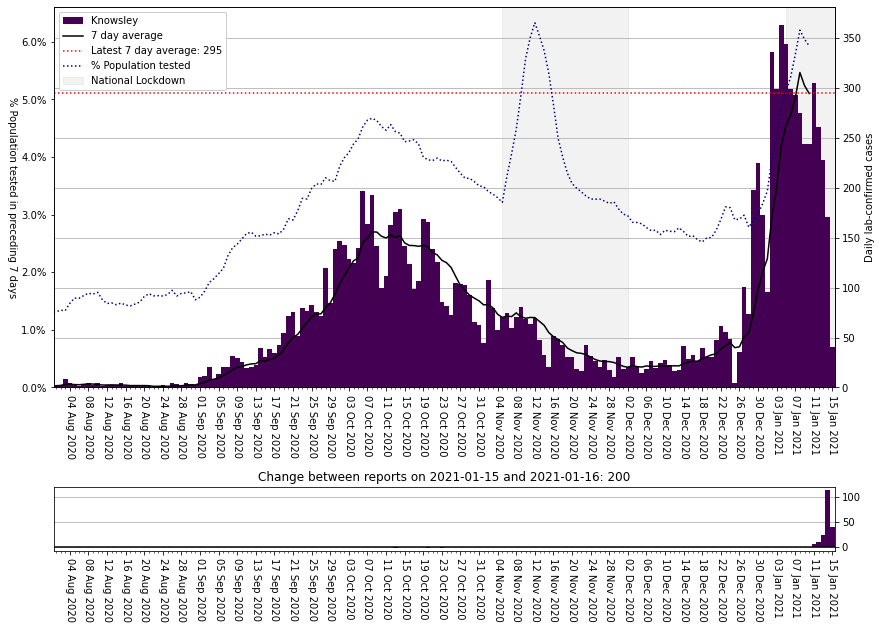

In [9]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [10]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"cases per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000025,Birmingham,616.298948,7037.0,2021-01-15
E08000012,Liverpool,743.110019,3701.0,2021-01-15
E06000058,"Bournemouth, Christchurch and Poole",700.678672,2770.0,2021-01-15
E09000025,Newham,769.396320,2717.0,2021-01-15
E08000028,Sandwell,790.379053,2596.0,2021-01-15
E09000005,Brent,766.895816,2529.0,2021-01-15
E09000009,Ealing,734.919808,2512.0,2021-01-15
E09000008,Croydon,622.947428,2409.0,2021-01-15
E09000003,Barnet,568.622448,2251.0,2021-01-15


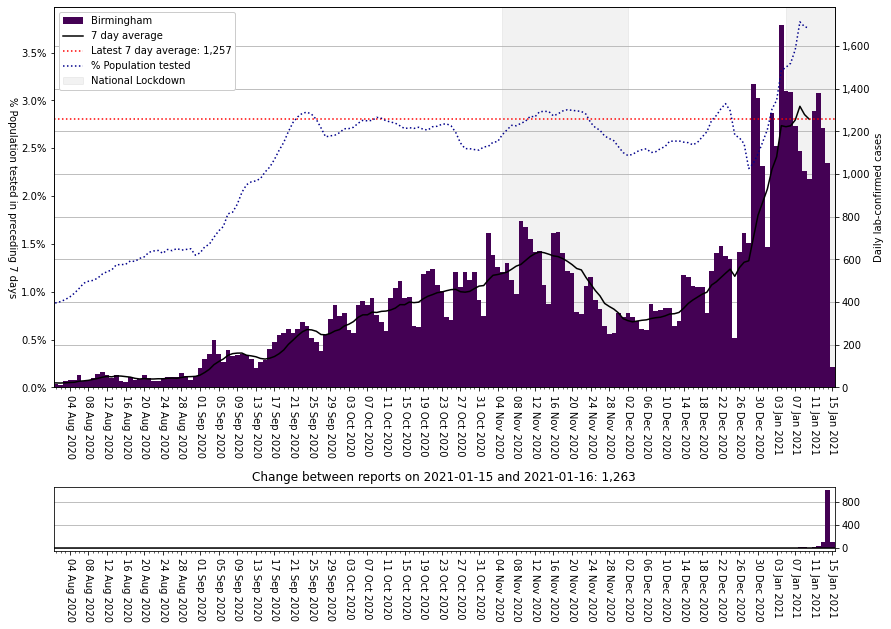

In [11]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [3]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)

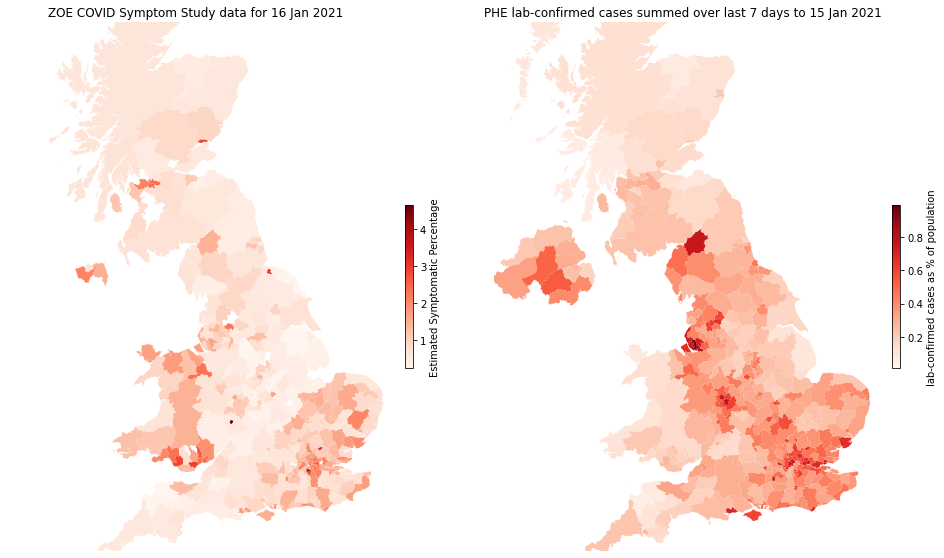

In [4]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [4]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

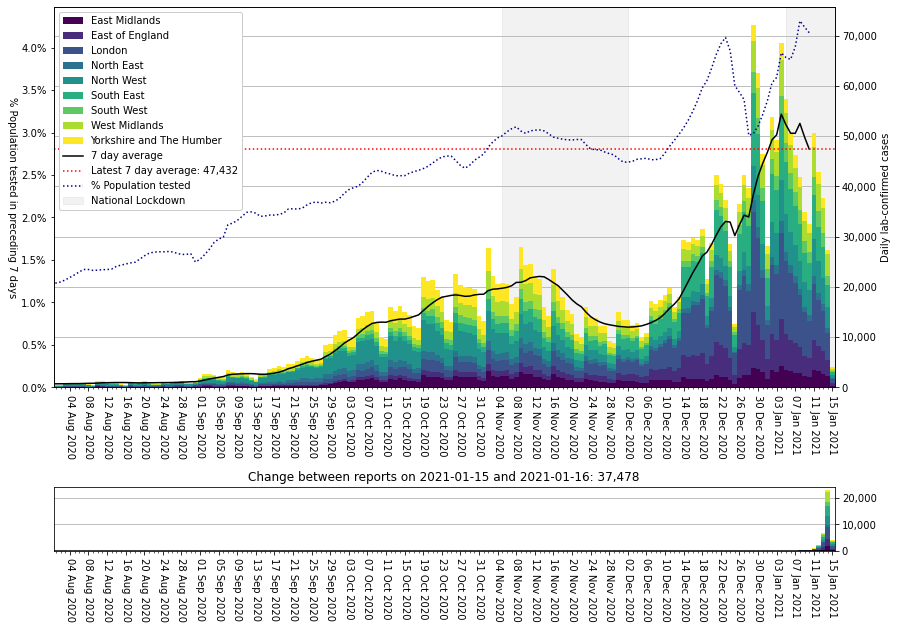

In [33]:
plot_areas(for_date, area_type=region)

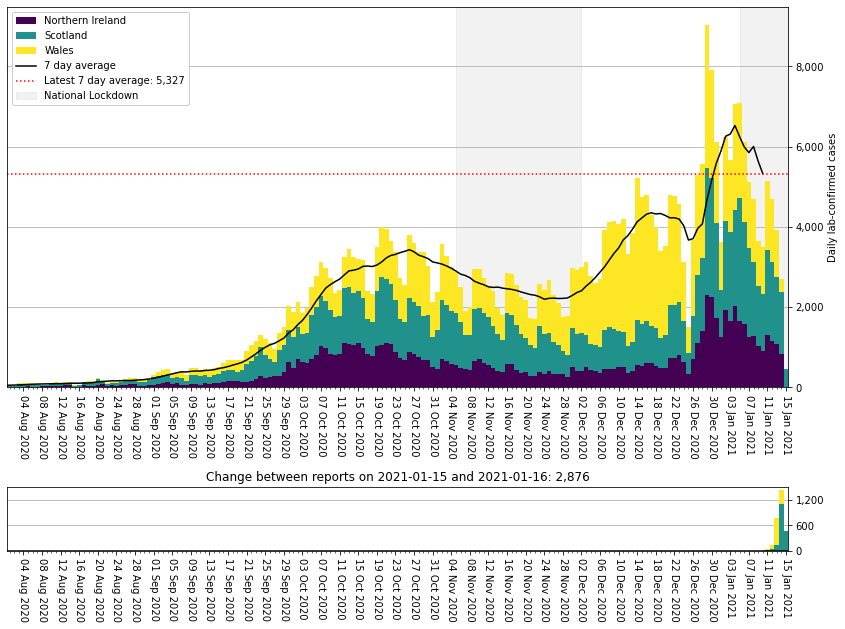

In [32]:
plot_areas(for_date, area_type=nation, areas=[scotland, northern_ireland, wales], show_testing=False)